# Code

In [1]:
import pandas as pd
import os
import time
import numpy as np
import sys
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '..')
import dataset.preprocessing as utils
from config import *

### Pre-processing

In [2]:
def order_genes(x):
    x1, x2 = x.split('_')
    return utils.get_couple_id(x1, x2)

In [3]:
df_hub = utils.read_dataframe(os.path.join(original_files_dir, 'hub.table.paris.txt'), columns_to_drop = ['Unnamed: 0','gene_name']).rename({'cell_line': 'cell_line_set', 'degree':'n_interactors', 'gene_type': 'gene_type_set', 'species': 'species_set'}, axis = 1)
tx = utils.read_dataframe(os.path.join(original_files_dir,'tx_regions.ens99.txt'), columns_to_drop = ['Unnamed: 0','ensembl_transcript_id']).rename({'ensembl_gene_id': 'gene_id'}, axis = 1)
df_genes = df_hub.merge(tx, on = 'gene_id')
assert df_genes.shape[0] == df_hub.shape[0]

FileNotFoundError: [Errno 2] No such file or directory: '/data01/giorgio/RNARNA-NT/dataset/original_files/hub.table.paris.txt'

In [4]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.no_cds_cds.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)
        
all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}

#all_interactions = all_interactions.filter(['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'experiment', 'name'], axis = 1)

#all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

all_interactions = all_interactions.filter(['experiment', 'name'], axis = 1)

paris_experiments = ['hs_PARIS1__Hela_highRNase', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__Hela_lowRNase', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293_AMT', 'hs_PARIS2__HEK293_Amoto']
mario_experiments = ['mm_MARIO__mES']
ricseq_experiments = ['hs_RIC-seq__HeLa_merge.InterGene.arms']

all_interactions = all_interactions[all_interactions['experiment'].isin(paris_experiments)].reset_index(drop = True)

In [5]:
int_or = utils.read_dataframe(os.path.join(original_files_dir, 'rise_paris_tr.new.mapped_interactions.tx_regions.txt'), columns_to_drop = ['Unnamed: 0',  'Unnamed: 0.1', 'gene_name1', 'gene_name2', 'type_interaction', 'score', 'tx_id_1', 'tx_id_2', 'tx_id_1_localization', 'tx_id_2_localization', 'unique_id'])
int_or = int_or.drop_duplicates().reset_index(drop = True)
all_rise_id = set(int_or.rise_id)
int_or = all_interactions.merge(int_or, left_on = 'name', right_on = 'rise_id').drop('name', axis = 1)
assert all_rise_id == set(int_or.rise_id)

In [6]:
#accorpiamo alcuni esperimenti per generare i negativi 
#[hs_PARIS2__HEK293_AMT, hs_PARIS2__HEK293_Amoto]
#[hs_PARIS1__Hela_highRNase, hs_PARIS1__Hela_lowRNase]

all_interactions.loc[all_interactions["experiment"] == "hs_PARIS2__HEK293_AMT", "experiment"] = "hs_PARIS2__HEK293"
all_interactions.loc[all_interactions["experiment"] == "hs_PARIS2__HEK293_Amoto", "experiment"] = "hs_PARIS2__HEK293"

int_or.loc[int_or["experiment"] == "hs_PARIS2__HEK293_AMT", "experiment"] = "hs_PARIS2__HEK293"
int_or.loc[int_or["experiment"] == "hs_PARIS2__HEK293_Amoto", "experiment"] = "hs_PARIS2__HEK293"


all_interactions.loc[all_interactions["experiment"] == "hs_PARIS1__Hela_highRNase", "experiment"] = "hs_PARIS1__Hela"
all_interactions.loc[all_interactions["experiment"] == "hs_PARIS1__Hela_lowRNase", "experiment"] = "hs_PARIS1__Hela"

int_or.loc[int_or["experiment"] == "hs_PARIS1__Hela_highRNase", "experiment"] = "hs_PARIS1__Hela"
int_or.loc[int_or["experiment"] == "hs_PARIS1__Hela_lowRNase", "experiment"] = "hs_PARIS1__Hela"

paris_experiments = ['hs_PARIS1__Hela', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293']

In [7]:
how_many_negatives_per_positive = 2 

df_pairs_full = []
for exp in paris_experiments:
    df_exp = int_or[int_or.experiment == exp][['gene_id1', 'gene_id2']].drop_duplicates().reset_index(drop = True)
    df_exp['positive'] = df_exp['gene_id1'] + '_' + df_exp['gene_id2']
    for i in range(how_many_negatives_per_positive):
        df_exp['gene_id2'] = df_exp.sample(frac=1, replace=False, random_state=42).reset_index(drop = True)['gene_id2']
        df_exp[f'negative{i}'] = df_exp['gene_id1'] + '_' + df_exp['gene_id2']
    df_exp['experiment'] = exp
    df_pairs_full.append(df_exp[['positive', 'negative0', 'negative1', 'experiment']])
df_pairs_full = pd.concat(df_pairs_full, axis = 0)
assert set(df_pairs_full.positive) == set(int_or['gene_id1'] + '_' + int_or['gene_id2'])

df_pairs_full = pd.concat([
    df_pairs_full[['positive', 'negative0', 'experiment']].rename({'negative0':'negative'}, axis = 1),
    df_pairs_full[['positive', 'negative1', 'experiment']].rename({'negative1':'negative'}, axis = 1)
], axis = 0)

df_pairs_full['negative'] = df_pairs_full['negative'].apply(order_genes)
df_pairs_full['positive'] = df_pairs_full['positive'].apply(order_genes)

assert set(df_pairs_full.positive) == set((int_or['gene_id1'] + '_' + int_or['gene_id2']).apply(order_genes))

#### Drop all the negative interactions that are seen positive in PARIS or in other experiments

In [8]:
prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']
prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)
print(len(set(df_pairs_full.negative)))

df_pairs_full = df_pairs_full[~df_pairs_full.negative.isin(prohibited_couples['id'])].reset_index(drop = True)
print(len(set(df_pairs_full.negative)))

162704
160464


In [9]:
to_drop = set(df_pairs_full['positive']).intersection(df_pairs_full['negative'])

print('how many to drop', len(to_drop))

df_pairs_full = df_pairs_full[~df_pairs_full['negative'].isin(to_drop)]

print(f'We have {len(set(df_pairs_full.positive))} pairs interacting (they can have multiple interactions) \n')
print(f'We have {len(set(df_pairs_full.negative))} pairs not interacting \n')

how many to drop 0
We have 80338 pairs interacting (they can have multiple interactions) 

We have 160464 pairs not interacting 



In [10]:
# FIXING df_pairs_full
# it can happen that few positive samples are not included in df_pairs_full because I have excluded some rows

int_or[['couples', 'need_to_swap']] = int_or[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)

not_included = set(int_or.couples) - set(df_pairs_full.positive).union(set(df_pairs_full.negative))

int_or_not_incl = int_or[int_or.couples.isin(not_included)]
int_or_not_incl = int_or[int_or.couples.isin(not_included)][['couples', 'experiment']]
int_or_not_incl = int_or_not_incl.drop_duplicates(subset = 'couples')
int_or_not_incl = int_or_not_incl.reset_index(drop = True)
c = int_or_not_incl.couples.str.extractall('(.*)_(.*)').reset_index()
int_or_not_incl['gene1'], int_or_not_incl['gene2'] = c[0], c[1]



df_pairs_full2 = []
for _, row in int_or_not_incl.iterrows():
    subset_df_pairs_full = df_pairs_full[df_pairs_full.experiment == row.experiment].reset_index()
    
    p = subset_df_pairs_full.positive.str.extractall('(.*)_(.*)').reset_index()
    n = subset_df_pairs_full.negative.str.extractall('(.*)_(.*)').reset_index()
    subset_df_pairs_full['p0'], subset_df_pairs_full['p1'] = p[0], p[1]
    subset_df_pairs_full['n0'], subset_df_pairs_full['n1'] = n[0], n[1]
    
    subset_df_pairs_full = subset_df_pairs_full[
            (subset_df_pairs_full['n0'] == row.gene1)|(subset_df_pairs_full['n0'] == row.gene2)|
            (subset_df_pairs_full['n1'] == row.gene1)|(subset_df_pairs_full['n1'] == row.gene2)
    ] 
    neg_sampled = subset_df_pairs_full.sample(1).negative.iloc[0]
    df_pairs_full2.append({'positive': row.couples, 'negative':neg_sampled, 'experiment': exp})

df_pairs_full = pd.concat([df_pairs_full, pd.DataFrame(df_pairs_full2)], axis = 0).reset_index(drop = True)

assert set(int_or.couples) - set(df_pairs_full.positive).union(set(df_pairs_full.negative)) == set()

In [11]:
# EXPORT
df_pairs_full.to_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM.csv'), index = False)

### Gene info df

In [12]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))

### Clean bounding boxes of df interactions

In [13]:
df_int = pd.read_csv(os.path.join(processed_files_dir, 'full_paris_info_interactions.csv'))

df_int = df_int[['couples', 'gene1', 'gene2', 
                 'interacting', 'length_1', 'length_2',
                 'protein_coding_1', 'protein_coding_2',
                 'x1', 'y1', 'w', 'h']]

df_neg = df_pairs_full[['negative']].drop_duplicates().reset_index(drop = True)
df_neg[['gene1', 'gene2']] = df_neg['negative'].str.split('_', expand = True)
df_neg = df_neg.rename({'negative':'couples'}, axis = 1)

df_neg['interacting'] = False
df_neg = df_neg.merge(df_genes[['gene_id', 'length', 'protein_coding']], left_on = 'gene1', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'length': 'length_1','protein_coding':'protein_coding_1'} , axis = 1)
df_neg = df_neg.merge(df_genes[['gene_id', 'length', 'protein_coding']], left_on = 'gene2', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'length': 'length_2','protein_coding':'protein_coding_2'} , axis = 1)


assert (set(df_pairs_full.negative) - set(df_neg.couples) == {np.nan})|(set(df_pairs_full.negative) - set(df_neg.couples) == set()) # I have some NaN in the df_pairs_full

df_int1 = df_int[['gene1', 'x1', 'w']].rename({'gene1':'gene', 'x1':'c1',  'w': 'l'}, axis = 1)
df_int2 = df_int[['gene2', 'y1', 'h']].rename({'gene2':'gene', 'y1':'c1',  'h': 'l'}, axis = 1)
df_coord = pd.concat([df_int1, df_int2], ignore_index = True)#.drop_duplicates().reset_index(drop = True)
#df_coord may have duplicates. but this is something I want. If a gene appears more than once, I want it to be sampled according to its distribution.

assert set(df_neg.gene1).union(set(df_neg.gene2)) - set(df_coord.gene) == set()

### Create fake negative interactions

In [14]:
df_coord = df_coord.merge(
    df_genes.filter(['gene_id', 'UTR5', 'CDS', 'UTR3', 'protein_coding'], axis = 1).rename({'gene_id':'gene'}, axis = 1)
)
df_coord['where_c1'] = df_coord.apply(utils.where_interacts, axis = 1)

In [ ]:
#127 min
start_time = time.time()
new_cols = df_neg[['couples', 'gene1', 'gene2']].apply(utils.create_fake_coord_neg, axis = 1, args = (df_coord,df_pairs_full,df_int,))
print(f"Total time: {(time.time()-start_time)/60} minutes")

In [ ]:
new_cols = new_cols.apply(pd.Series).rename({0:'x1', 1:'y1', 2:'w', 3:'h'}, axis = 1)
df_neg = pd.concat([df_neg, new_cols], axis = 1)
df = pd.concat([df_int, df_neg], ignore_index = True, axis = 0)

Now I do checks

In [15]:
#check if it worked
assert (df_neg.x1 <= df_neg.length_1).all()
assert ((df_neg.x1 + df_neg.w) <= df_neg.length_1).all()
assert (df_neg.y1 <= df_neg.length_2).all()
assert ((df_neg.y1 + df_neg.h) <= df_neg.length_2).all()

# 37 min
#check if it worked
start_time = time.time()
for _, row in df_neg.iterrows():
    g1 = row.gene1
    g2 = row.gene2
    assert [row.x1, row.w] in df_coord[df_coord.gene == g1][['c1', 'l']].values
    assert [row.y1, row.h] in df_coord[df_coord.gene == g2][['c1', 'l']].values
    if np.random.rand() < 0.0003: #progress
        print(f"{np.round(_/df_neg.shape[0] * 100, 2)}% in {(time.time()-start_time)/60} minutes")
print(f"Total time: {(time.time()-start_time)/60} minutes")

In [3]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv'))

df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM.csv'))

In [7]:
### ADD EXPERIMENT COLUMN

df_int, df_neg = df[df.interacting],  df[df.interacting == False]

int_or = int_or.filter(['experiment', 'start_map1', 'end_map1', 'start_map2', 'end_map2', 'rise_id', 'gene_id1', 'gene_id2', 'method'], axis = 1)
int_or = int_or.rename({'start_map1':'x1', 'end_map1':'x2', 'start_map2':'y1', 'end_map2':'y2'}, axis = 1)

int_or[['couples', 'need_to_swap']] = int_or[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)

def swap_genes_if_needed(df):
    original_dim = df.shape[0]
    where = df.need_to_swap
    df.loc[where, ['gene_id1', 'gene_id2']] = (df.loc[where, ['gene_id2', 'gene_id1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df = df.drop('need_to_swap', axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    n_duplicates = original_dim - df.shape[0] 
    return df

int_or = swap_genes_if_needed(int_or)
int_or['w'] = int_or['x2'] -  int_or['x1']
int_or['h'] = int_or['y2'] -  int_or['y1']
int_or = int_or.drop(['x2', 'y2', 'gene_id1', 'gene_id2'], axis = 1)

merged = df_int.merge(int_or, on = ['couples', 'x1', 'w', 'y1', 'h']).reset_index(drop = True)

# If I have multiple interactions of different experiments mapping to the same region, I keep only one of them
merged = merged.drop_duplicates(subset = ['couples', 'x1', 'w', 'y1', 'h']).reset_index(drop = True)

merged2 = df_int.merge(int_or, on = ['couples', 'x1', 'w', 'y1', 'h'], how = 'left').reset_index(drop = True)
collapsed_int = merged2[merged2.experiment.isna()].reset_index(drop = True)
collapsed_int = collapsed_int.fillna('unknwn_collapsed_interactions')

assert merged.shape[0] + collapsed_int.shape[0] == df_int.shape[0]

assert set(df_int.couples) == set(collapsed_int.couples).union(merged.couples)

# add to positive df
df_int = pd.concat([merged, collapsed_int], axis = 0)

# add to negative df

df_neg['rise_id'] = 'is_negative'
df_neg = df_neg.merge(df_pairs_full[['negative', 'experiment']], left_on = 'couples', right_on = 'negative').drop('negative', axis = 1)
df_neg['method'] = df_neg['experiment'].str.extractall('(.*)_(.*)__(.*)').reset_index()[1]
df_neg = df_neg.filter(list(df_int.columns), axis = 1)

# If I have multiple interactions of different experiments mapping to the same region, I keep only one of them
df_neg = df_neg.drop_duplicates(subset = ['couples', 'x1', 'w', 'y1', 'h']).reset_index(drop = True)

/tmp/ipykernel_1764902/3101936988.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['rise_id'] = 'is_negative'


In [8]:
df = pd.concat([df_int, df_neg], ignore_index = True, axis = 0)

In [23]:
# ADD THE SPECIE COLUMN

mouse_genes = list(df_genes[df_genes.species_set == "{'mm'}"].gene_id)

df['specie'] = 'human'

df.loc[ (df.gene1.isin(mouse_genes))&(df.gene2.isin(mouse_genes)), 'specie'] = 'mouse'

assert set(df[(df.gene1.isin(mouse_genes))&(df.gene2.isin(mouse_genes))].specie) == set({'mouse'})

In [118]:
df = df.drop_duplicates().reset_index(drop=True)
df.to_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv'), index = False)

# Plots 

### Interaction Length distribution

In [3]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv'))
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))

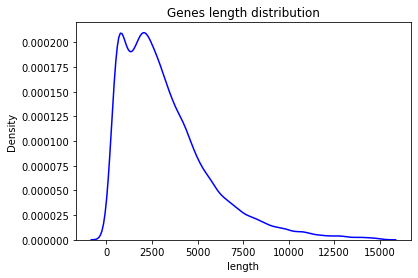

2705.0
3177.7260677708364
205012


In [5]:
sns.kdeplot(df_genes[df_genes.length<15_000].length, color = 'blue')
plt.title(f'Genes length distribution')
plt.show()
print(df_genes.length.median())
print(df_genes.length.std())
print(df_genes.length.max())

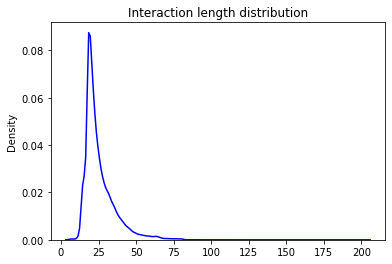

In [6]:
df_int = df[df.interacting]
lengths = list(pd.concat([df_int.w, df_int.h]))
sns.kdeplot(lengths, color = 'blue')
plt.title(f'Interaction length distribution')
plt.show()

In [7]:
treshold = 25
perc = np.round(df_int[(df_int.w > treshold) & (df_int.h > treshold)].shape[0]/df_int.shape[0] * 100, 2)
print(f'If I take only the couples where both interaction regions are > {treshold} bp, I have the {perc}% of the dataset')

If I take only the couples where both interaction regions are > 25 bp, I have the 15.65% of the dataset


### Degree

In [8]:
def obtain_gene_count_real(df):
    vc = df.interacting.value_counts()
    if set(vc.index) == {False, True}:
        unbalance_factor = vc[True]/vc[False]
    else:
        unbalance_factor = np.nan
    gene_count_pos_list = list(df[df.interacting].gene1) + list(df[df.interacting].gene2)
    gene_count_neg_list = list(df[df.interacting == False].gene1) + list(df[df.interacting == False].gene2)

    gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
    gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
    gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
    
    gene_count_res['weight'] = 1
    gene_count_res.loc[ gene_count_res.interacting == 0, 'weight'] = unbalance_factor
    gene_count_real = gene_count_res.groupby('gene').sum()
    gene_count_real['not_interacting'] = gene_count_real['weight'] - gene_count_real['interacting']
    gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
    gene_count_real['total'] = gene_count_real['not_interacting'] + gene_count_real['interacting']
    gene_count_real = gene_count_real.reset_index()#add gene column
    return gene_count_real

In [9]:
gene_count = obtain_gene_count_real(df)

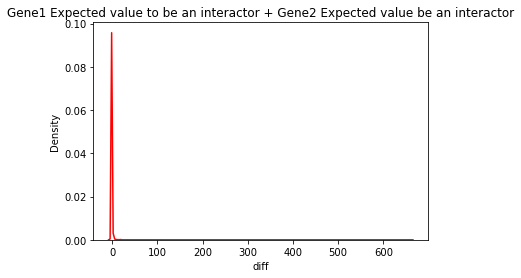

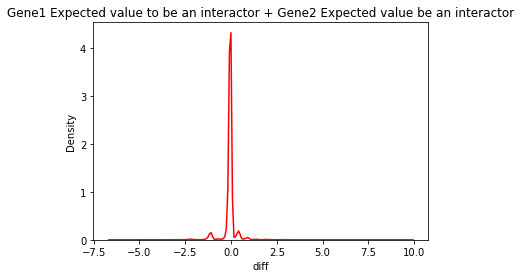

percentage of genes within the tolerance treshold 0.999 %
percentage of data within the tolerance treshold 0.908 %


In [10]:
tolerance = 10

sns.kdeplot(gene_count['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

sns.kdeplot(gene_count[gene_count['diff']<tolerance]['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()


subset = gene_count[(gene_count['diff']<tolerance)&(gene_count['diff']>-tolerance)]
subset_treshold = df[(df.gene1.isin(subset.gene)&df.gene2.isin(subset.gene))]

print(f'percentage of genes within the tolerance treshold {(subset.shape[0] / gene_count.shape[0]):.3f} %')
print(f'percentage of data within the tolerance treshold {(subset_treshold.shape[0] / df.shape[0]):.3f} %')

### CDS-CDS enrichment?

In [11]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv')) #final_df_RANDOM
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))[['gene_id', 'CDS', 'UTR5', 'UTR3']]

In [12]:
def create_interactions_columns(df, df_genes):

    df = df.merge(df_genes, left_on = 'gene1', right_on = 'gene_id')
    df['where_x1'] = 'none'
    df.loc[(df.x1 < df.UTR5), 'where_x1'] = 'UTR5'
    df.loc[(df.x1 >= df.UTR5)&(df.x1 < df.CDS), 'where_x1'] = 'CDS'
    df.loc[(df.x1 >= df.CDS), 'where_x1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    
    df = df.merge(df_genes, left_on = 'gene2', right_on = 'gene_id')
    df['where_y1'] = 'none'
    df.loc[(df.y1 < df.UTR5), 'where_y1'] = 'UTR5'
    df.loc[(df.y1 >= df.UTR5)&(df.y1 < df.CDS), 'where_y1'] = 'CDS'
    df.loc[(df.y1 >= df.CDS), 'where_y1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    return df

def where_interacts(x):
    a,b = sorted([x.where_x1, x.where_y1])
    return a + '-' + b

df = create_interactions_columns(df, df_genes)
df['where'] = df.apply(where_interacts,axis = 1)

In [13]:
def plot_interaction_region(df):
    df_int, df_neg = df[df.interacting == True], df[df.interacting == False]
    
    # PLOT 
    categories = list(set(df_int['where'].value_counts().index).union(df_neg['where'].value_counts().index))

    neg = df_neg['where'].value_counts()
    neg = pd.Series([neg.get(key, 0) for key in categories], index=categories)

    pos = df_int['where'].value_counts()
    pos = pd.Series([pos.get(key, 0) for key in categories], index=categories)

    values1 = pos.values

    values2 = neg.values

    total1 = sum(values1)
    total2 = sum(values2)

    percentages1 = np.array([value / total1 * 100 for value in values1])
    percentages2 = np.array([value / total2 * 100 for value in values2])

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots(figsize=(12, 8))
    bar1 = ax.bar(index, percentages1, bar_width, label='Positive Distribution', color='skyblue')
    bar2 = ax.bar(index + bar_width, percentages2, bar_width, label='Negative Distribution', color='orange')

    ax.set_xlabel('Categories')
    ax.set_ylabel('Percentage')
    ax.set_title('Comparison of Two Distributions')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

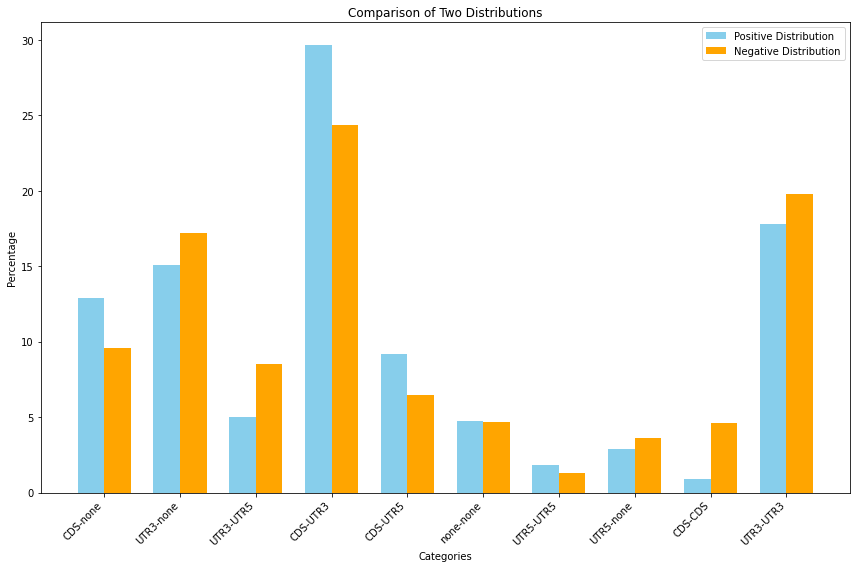

In [14]:
plot_interaction_region(df)

# Train-test-val split

Esegui DEGREE e CDS-CDS ENRICHMENT prima di questo

In [15]:
from sklearn.model_selection import train_test_split
import dataset.train_test_val_utils as utils
import pickle

In [16]:
df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM.csv')).sample(frac=1).drop_duplicates().reset_index(drop = True)
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))

df_pairs_full['gene1'] = df_pairs_full.positive.str.split('_', expand = True)[0]
df_pairs_full['gene2'] = df_pairs_full.positive.str.split('_', expand = True)[1]
df_pairs_full['gene1_neg'] = df_pairs_full.negative.str.split('_', expand = True)[0]
df_pairs_full['gene2_neg'] = df_pairs_full.negative.str.split('_', expand = True)[1]

assert set(df_pairs_full.gene1).union(set(df_pairs_full.gene2)) - set(df_genes.gene_id) == set() 
assert set(df_pairs_full.gene1_neg).union(set(df_pairs_full.gene2_neg)) - set(df_genes.gene_id).union({np.nan}) == set() 

df_pairs_full = df_pairs_full.merge(df_genes[['gene_id', 'species_set']], left_on = 'gene1', right_on = 'gene_id').drop('gene_id', axis = 1)

In [69]:
# train = df[~(df['experiment']=='hs_PARIS1__HEK293T')]
# testval = df[(df['experiment']=='hs_PARIS1__HEK293T')]
# assert train.shape[0] + testval.shape[0] == df.shape[0]

# test_size = testval.shape[0]//2
# testval = testval.sample(frac = 1)

# test = testval.head(test_size)
# val = testval.tail(testval.shape[0] - test_size)

# assert test.shape[0] + val.shape[0] == testval.shape[0]

# gene_pairs_training = list(set(train.couples))
# gene_pairs_test = list(set(test.couples))
# gene_pairs_val = list(set(val.couples))

# save_path = '/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/RANDOM'

# file_names = ['gene_pairs_training.txt', 'gene_pairs_test.txt', 'gene_pairs_val.txt']
# file_name_training, file_name_test, file_name_val = file_names
# file_training = os.path.join(save_path, file_name_training)
# file_test = os.path.join(save_path, file_name_test)
# file_val = os.path.join(save_path, file_name_val)

# with open(file_training, "wb") as fp:   #Pickling
#     pickle.dump(gene_pairs_training, fp)

# with open(file_test, "wb") as fp:   #Pickling
#     pickle.dump(gene_pairs_test, fp)

# with open(file_val, "wb") as fp:   #Pickling
#     pickle.dump(gene_pairs_val, fp)

In [17]:
#circa 5 min
gene_pairs_training, gene_pairs_test, gene_pairs_val = utils.create_or_load_train_test_val(df_pairs_full, save_path = '/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/RANDOM')

progress around 7.92%
progress around 8.81%
progress around 9.77%
progress around 10.3%
progress around 14.31%
progress around 16.61%
progress around 1.23%
progress around 3.77%
progress around 6.64%
progress around 17.16%
progress around 17.3%
progress around 18.87%
progress around 19.09%
progress around 1.32%
progress around 16.35%
progress around 0.73%
progress around 3.92%
progress around 9.33%
progress around 10.45%
progress around 17.68%
Total time: 4.447775467236837 minutes


In [18]:
all_possible_pairs = set(df_pairs_full.positive).union(set(df_pairs_full.negative))

assert set(gene_pairs_training).union(set(gene_pairs_val)).union(set(gene_pairs_test)) == all_possible_pairs == set(df.couples)

print('tot:',len(all_possible_pairs))

print('- - - split - - -')

print('train:', len(set(gene_pairs_training)))

print('test:', len(set(gene_pairs_test)))

print('val:', len(set(gene_pairs_val)))

file_train = os.path.join('/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/RANDOM', "gene_pairs_training.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
df_train = pd.DataFrame({'couples':gene_pairs_train})
regex = df_train['couples'].str.extractall('(.*)_(.*)').reset_index()
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))
couples_train = set(df_train['couples'])

file_test = os.path.join('/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/RANDOM', "gene_pairs_test.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
df_test = pd.DataFrame({'couples':gene_pairs_test})
regex = df_test['couples'].str.extractall('(.*)_(.*)').reset_index()
df_test['g1'] = regex[0]
df_test['g2'] = regex[1]
df_test_genes = set(df_test['g1']).union(set(df_test['g2']))
couples_test = set(df_test['couples'])

file_val = os.path.join('/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/RANDOM', "gene_pairs_val.txt")
with open(file_val, "rb") as fp:   # Unpickling
    gene_pairs_val = pickle.load(fp)
df_val = pd.DataFrame({'couples':gene_pairs_val})
regex = df_val['couples'].str.extractall('(.*)_(.*)').reset_index()
df_val['g1'] = regex[0]
df_val['g2'] = regex[1]
df_val_genes = set(df_val['g1']).union(set(df_val['g2']))
couples_val = set(df_val['couples'])

tot: 240957
- - - split - - -
train: 173052
test: 34567
val: 33350


In [19]:
print('# of couples between train and val', len(couples_val.intersection(couples_train)) )
print('# of couples between train and test', len(couples_train.intersection(couples_test)) )
print('# of couples between val and test', len(couples_val.intersection(couples_test)) )

# of couples between train and val 0
# of couples between train and test 0
# of couples between val and test 12


In [20]:
couples_test_val = couples_test.union(couples_val)
all_couples = couples_test_val.union(couples_train)

print('# of total couples: ', len(all_couples))
train_perc = np.round(len(couples_train)/len(all_couples)*100,2)
test_perc = np.round(len(couples_test)/len(all_couples)*100,2)
val_perc = np.round(len(couples_val)/len(all_couples)*100,2)
print(f'La percentuale di coppie nel training è {train_perc}')
print(f'La percentuale di coppie nel test è {test_perc}')
print(f'La percentuale di coppie nel validation è {val_perc}')

test_not_in_train = df_test[~(df_test.g1.isin(df_train_genes) | df_test.g2.isin(df_train_genes))]
test_not_in_train = set(test_not_in_train.couples)
val_not_in_train = df_val[~(df_val.g1.isin(df_train_genes) | df_val.g2.isin(df_train_genes))]
val_not_in_train = set(val_not_in_train.couples)

perc_test_notrain = np.round(len(test_not_in_train)/len(couples_test)*100, 2)
perc_val_notrain = np.round(len(val_not_in_train)/len(couples_val)*100, 2)

print(f'La percentuale di coppie nel test non nel training (rispetto al totale del test set) è {perc_test_notrain}')
print(f'La percentuale di coppie nel validation non nel training (rispetto al totale del validation set) è {perc_val_notrain}')
print(f'Il numero di coppie nel test non nel training è {len(test_not_in_train)}')
print(f'Il numero di coppie nel test (positive) non nel training è  {len(set(df[df.couples.isin(test_not_in_train)&df.interacting].couples))}')
print(f'Il numero di coppie nel val non nel training è {len(val_not_in_train)}')
print(f'Il numero di coppie nel val (positive) non nel training è  {len(set(df[df.couples.isin(val_not_in_train)&df.interacting].couples))}')

# of total couples:  240957
La percentuale di coppie nel training è 71.82
La percentuale di coppie nel test è 14.35
La percentuale di coppie nel validation è 13.84
La percentuale di coppie nel test non nel training (rispetto al totale del test set) è 1.11
La percentuale di coppie nel validation non nel training (rispetto al totale del validation set) è 0.8
Il numero di coppie nel test non nel training è 383
Il numero di coppie nel test (positive) non nel training è  149
Il numero di coppie nel val non nel training è 267
Il numero di coppie nel val (positive) non nel training è  96


In [21]:
# df_labels = df[['couples', 'interacting']].drop_duplicates().reset_index(drop = True)
# assert df_labels.shape[0] == len(df['couples'].unique())
# df_labels['interacting'] = df_labels['interacting'].astype('int')


# train, test_val = train_test_split(df_labels, test_size=0.3, random_state=0, stratify=df_labels[['interacting']])
# test, val = train_test_split(test_val, test_size=0.5, random_state=0, stratify=test_val[['interacting']])

# gene_pairs_training = list(set(train.couples))
# gene_pairs_test = list(set(val.couples))
# gene_pairs_val = list(set(test.couples))
# utils.venn_between_genes(gene_pairs_training, gene_pairs_test, gene_pairs_val)

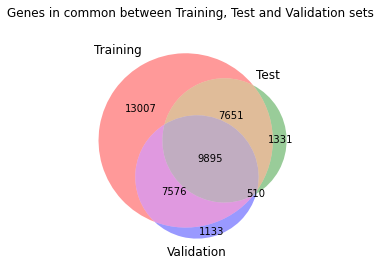

In [22]:
utils.venn_between_genes(gene_pairs_training, gene_pairs_test, gene_pairs_val)

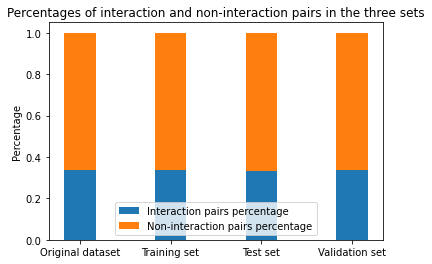

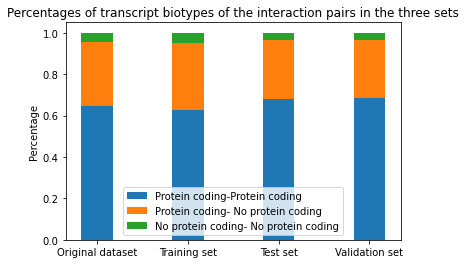

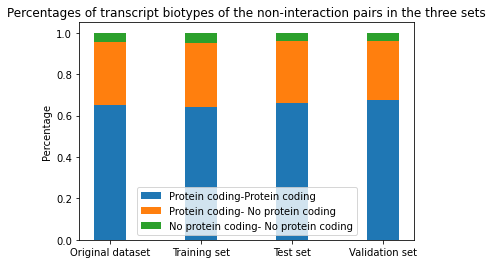

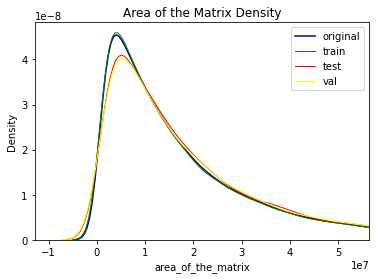

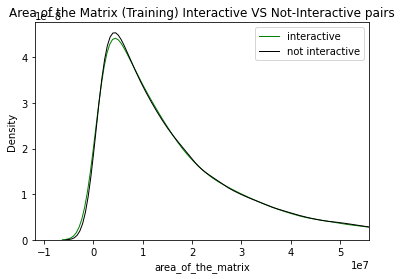

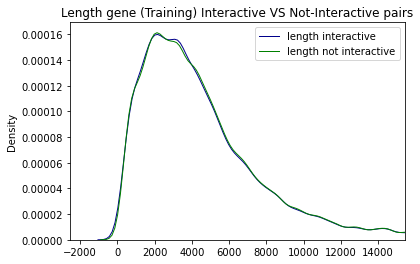

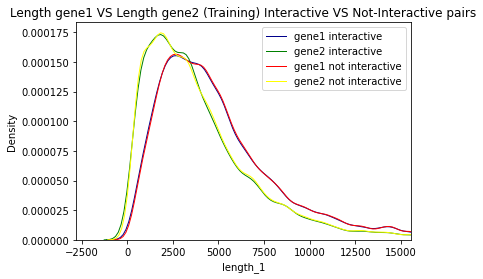

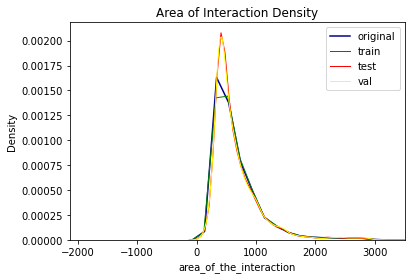

In [23]:
utils.plot_stats(df, gene_pairs_training, gene_pairs_test, gene_pairs_val, limit_plot = 100000000)

In [24]:
df_train = df[df.couples.isin(gene_pairs_training)].reset_index(drop = True)
df_val = df[df.couples.isin(gene_pairs_val)].reset_index(drop = True)
df_test = df[df.couples.isin(gene_pairs_test)].reset_index(drop = True)

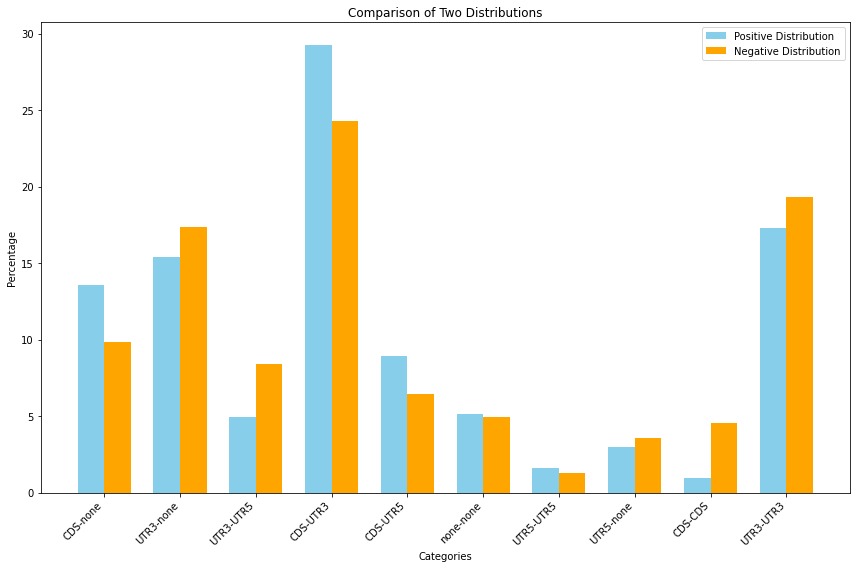

In [25]:
plot_interaction_region(df_train)

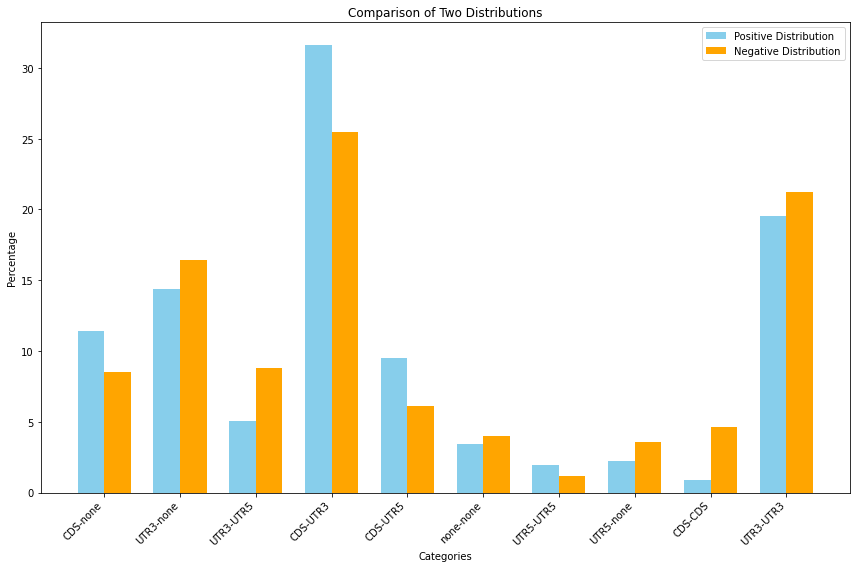

In [26]:
plot_interaction_region(df_val)

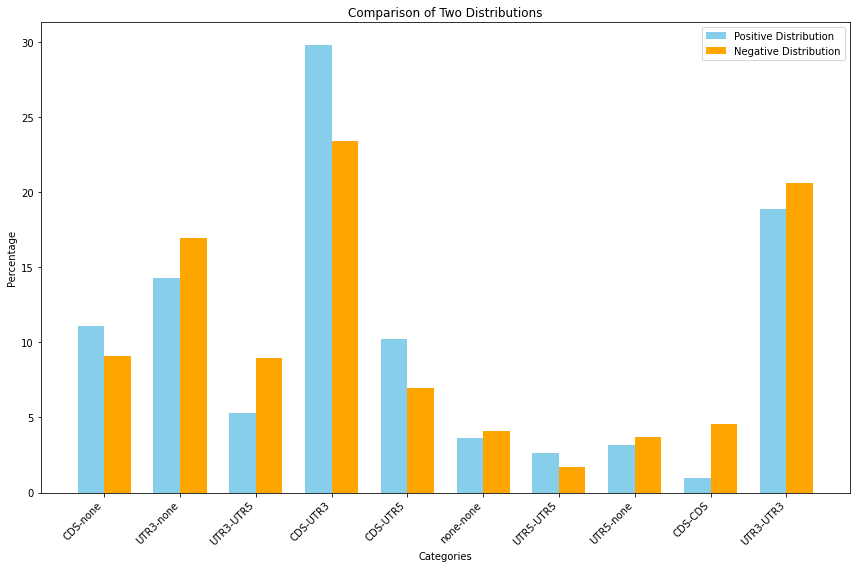

In [27]:
plot_interaction_region(df_test)

In [28]:
gene_count = obtain_gene_count_real(df)
tolerance = 10
subset = gene_count[(gene_count['diff']<tolerance)&(gene_count['diff']>-tolerance)]
subset_treshold = df_train[(df_train.gene1.isin(subset.gene)&df_train.gene2.isin(subset.gene))]

print(f'percentage of genes within the tolerance treshold {(subset.shape[0] / gene_count.shape[0]):.3f} %')
print(f'percentage of data within the tolerance treshold {(subset_treshold.shape[0] / df_train.shape[0]):.3f} %')

percentage of genes within the tolerance treshold 0.999 %
percentage of data within the tolerance treshold 0.900 %


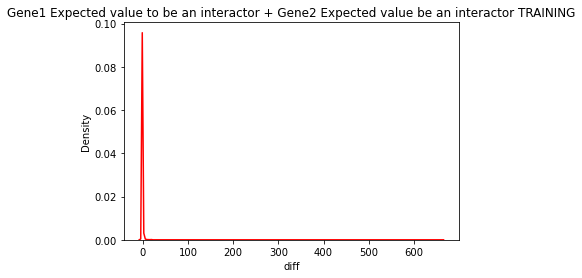

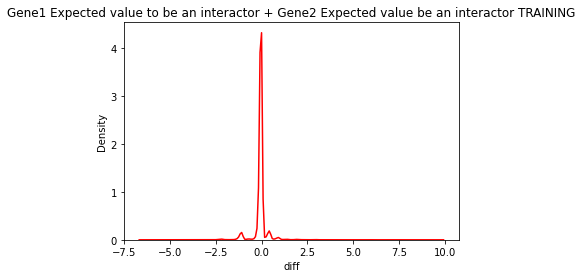

In [29]:
sns.kdeplot(gene_count['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor TRAINING')
plt.show()

sns.kdeplot(gene_count[(gene_count['diff']<tolerance)&(gene_count['diff']>-tolerance)]['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor TRAINING')
plt.show()

##### test-val creation with only the true (big) interaction regions

In [30]:
treshold = 20 #bigger than this number

def undersample(df):
    
    df = df[['couples', 'interacting']].drop_duplicates()
    
    negs = df[df.interacting == False]
    poss = df[df.interacting == True]
    
    vc = df.interacting.value_counts()
    if vc[False]>vc[True]:
        df = pd.concat([negs.sample(len(poss)), poss], axis = 0).sample(frac = 1).reset_index(drop = True)
    else:
        df = pd.concat([poss.sample(len(negs)), negs], axis = 0).sample(frac = 1).reset_index(drop = True)
        
    return df
        
df_train_sampled = df_train[(df_train.w > treshold)&(df_train.h > treshold)]
df_train_sampled = df_train_sampled[['couples', 'interacting']].drop_duplicates().reset_index(drop = True)
df_val_sampled = undersample(df_val[(df_val.w > treshold)&(df_val.h > treshold)])
df_test_sampled = undersample(df_test[(df_test.w > treshold)&(df_test.h > treshold)])

#export couples

In [31]:
df_train.interacting.value_counts()

False    115116
True      58940
Name: interacting, dtype: int64

In [32]:
df_train_sampled.interacting.value_counts()

False    41658
True     22959
Name: interacting, dtype: int64

In [33]:
df_val_sampled.interacting.value_counts()

False    4271
True     4271
Name: interacting, dtype: int64

In [34]:
df_test_sampled.interacting.value_counts()

False    4428
True     4428
Name: interacting, dtype: int64

In [35]:
gene_pairs_training = list(df_train_sampled.couples)
gene_pairs_test = list(df_test_sampled.couples)
gene_pairs_val = list(df_val_sampled.couples)

with open(os.path.join(rna_rna_files_dir, 'RANDOM', 'gene_pairs_training_HQ.txt'), "wb") as fp:   #Pickling
    pickle.dump(gene_pairs_training, fp)

with open(os.path.join(rna_rna_files_dir, 'RANDOM', 'gene_pairs_test_HQ.txt'), "wb") as fp:   #Pickling
    pickle.dump(gene_pairs_test, fp)

with open(os.path.join(rna_rna_files_dir, 'RANDOM', 'gene_pairs_val_HQ.txt'), "wb") as fp:   #Pickling
    pickle.dump(gene_pairs_val, fp)

##### test-val creation with only human / mouse

In [36]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv'))

In [37]:
for specie in ['human', 'mouse']:
    gene_pairs_training, gene_pairs_test, gene_pairs_val = utils.create_or_load_train_test_val(df_pairs_full, save_path = '/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/RANDOM')

    
    df_train = df[(df.couples.isin(gene_pairs_training))&(df.specie == specie)].reset_index(drop = True)
    df_val = df[(df.couples.isin(gene_pairs_val))&(df.specie == specie)].reset_index(drop = True)
    df_test = df[(df.couples.isin(gene_pairs_test))&(df.specie == specie)].reset_index(drop = True)
    
    with open(os.path.join(rna_rna_files_dir, 'RANDOM', f'gene_pairs_training_{specie}.txt'), "wb") as fp:   #Pickling
        pickle.dump(list(df_train.couples), fp)

    with open(os.path.join(rna_rna_files_dir, 'RANDOM', f'gene_pairs_test_{specie}.txt'), "wb") as fp:   #Pickling
        pickle.dump(list(df_test.couples), fp)

    with open(os.path.join(rna_rna_files_dir, 'RANDOM', f'gene_pairs_val_{specie}.txt'), "wb") as fp:   #Pickling
        pickle.dump(list(df_val.couples), fp)
        
    df_train_sampled = df_train[(df_train.w > treshold)&(df_train.h > treshold)]
    df_train_sampled = df_train_sampled[['couples', 'interacting']].drop_duplicates().reset_index(drop = True)
    df_val_sampled = undersample(df_val[(df_val.w > treshold)&(df_val.h > treshold)])
    df_test_sampled = undersample(df_test[(df_test.w > treshold)&(df_test.h > treshold)])
    
    gene_pairs_training = list(df_train_sampled.couples)
    gene_pairs_test = list(df_test_sampled.couples)
    gene_pairs_val = list(df_val_sampled.couples)
    
    with open(os.path.join(rna_rna_files_dir, 'RANDOM', f'gene_pairs_training_{specie}_HQ.txt'), "wb") as fp:   #Pickling
        pickle.dump(gene_pairs_training, fp)

    with open(os.path.join(rna_rna_files_dir, 'RANDOM', f'gene_pairs_test_{specie}_HQ.txt'), "wb") as fp:   #Pickling
        pickle.dump(gene_pairs_test, fp)

    with open(os.path.join(rna_rna_files_dir, 'RANDOM', f'gene_pairs_val_{specie}_HQ.txt'), "wb") as fp:   #Pickling
        pickle.dump(gene_pairs_val, fp)

Total time: 0.0003835161526997884 minutes
Total time: 0.0003650426864624023 minutes
